In [33]:
%load_ext autoreload
%autoreload 2
from utils import plot_utils
from utils import custom_functions as cuf

import os
import sys
#sys.path.append("../") # go to parent 
from OpenEphys_Analysis.utils.custom_functions import update_progress
import glob
import ntpath
import matplotlib
%matplotlib inline
import matplotlib.pylab as plt
import numpy as np
import math
import seaborn as sns
import pandas as pd
import warnings
from itertools import chain
import random

warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
# Task
BpodProtocol = '/Two_Alternative_Choice/'
# Behavioural data
GeneralDirectory = cuf.get_data_folder() + '/Behavioural_Data/Bpod_data/'

output_directory_name =  'D1andD2opto-learning_Dec21'

outputDir = GeneralDirectory + output_directory_name + '_Analysis/'
if not os.path.isdir(outputDir):
    print('I dont find this')
else:
    # Read the dataframe
    AnimalsDF = pd.read_pickle(outputDir + output_directory_name + '_dataframe.pkl')
    print('Dataframe read')

Dataframe read


In [35]:
# Select only the auditory when stimulation happened
protocols_selected = ['Auditory']
AnimalsDF = AnimalsDF[AnimalsDF.Protocol.isin(protocols_selected)]

stim_types = ['Right', 'Left']
AnimalsDF = AnimalsDF[AnimalsDF.Stimulation.isin(stim_types)]

In [36]:
# Remove the first 20 trials of each session
tr_beg_to_rem = 20
AnimalsDF = AnimalsDF[AnimalsDF['TrialIndex'] > tr_beg_to_rem]
print('Removed {} trials from the beginning of each session'.format(tr_beg_to_rem))

Removed 20 trials from the beginning of each session


In [37]:
# Generate random optostimulation choices for every session
n_times = 1000
data = np.empty([len(pd.unique(AnimalsDF['SessionID'])), 3], dtype=object)

for i, session in enumerate(pd.unique(AnimalsDF['SessionID'])):
    # generate the random dataset, and save it to a general dataframe for later use
    session_df = AnimalsDF[AnimalsDF['SessionID'] == session]
    roc = cuf.get_random_optolike_choices(df=session_df, n_times=n_times)
    _, odf = cuf.splitOpto(session_df)
    roc_ds = np.apply_along_axis(cuf.get_choices, 1, roc, trialsDif=odf['Difficulty'])
    avail_diffs = roc_ds[0,0,:]
    rand_choices_ds = roc_ds[:,1,:]
    # fill
    data[i] = [session, avail_diffs, rand_choices_ds]
    
    update_progress(i / len(pd.unique(AnimalsDF['SessionID'])))

random_opto_df = pd.DataFrame(data, columns=['SessionID', 'Difficulties', 'Random_choices'])
update_progress(1)

Progress: [####################] 100.0%


In [39]:
# Calculate the differences between the random choices and the opto ones to measure the bias

random_opto_df['bias'] = None
random_opto_df['bias_mean'] = None
random_opto_df['bias_std'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get data for opto
    opto_df = AnimalsDF[(AnimalsDF['SessionID'] == session) & (AnimalsDF['OptoStim']==1)]
    trialsDif = np.array(opto_df['TrialHighPerc'])
    sideSelected = np.array(opto_df['FirstPoke'])
    difficulty, opto_perf = cuf.get_choices(sideSelected, trialsDif)
    
    # get data for the shuffles
    
    updown_list = np.empty(n_times)
    for i in range(n_times):
        y_vals = random_opto_df.loc[session_idx].Random_choices[i]
        # calculate area and normalize
        updown_list[i] = np.sum(y_vals - opto_perf) / len(difficulty)
    
    random_opto_df.at[session_idx, 'bias'] = updown_list
    random_opto_df.at[session_idx, 'bias_mean'] = np.nanmean(updown_list)
    random_opto_df.at[session_idx, 'bias_std'] = np.nanstd(updown_list)
    
    update_progress((sc + 1) / len(pd.unique(random_opto_df['SessionID'])))

Progress: [####################] 100.0%


Progress: [####################] 100.0%


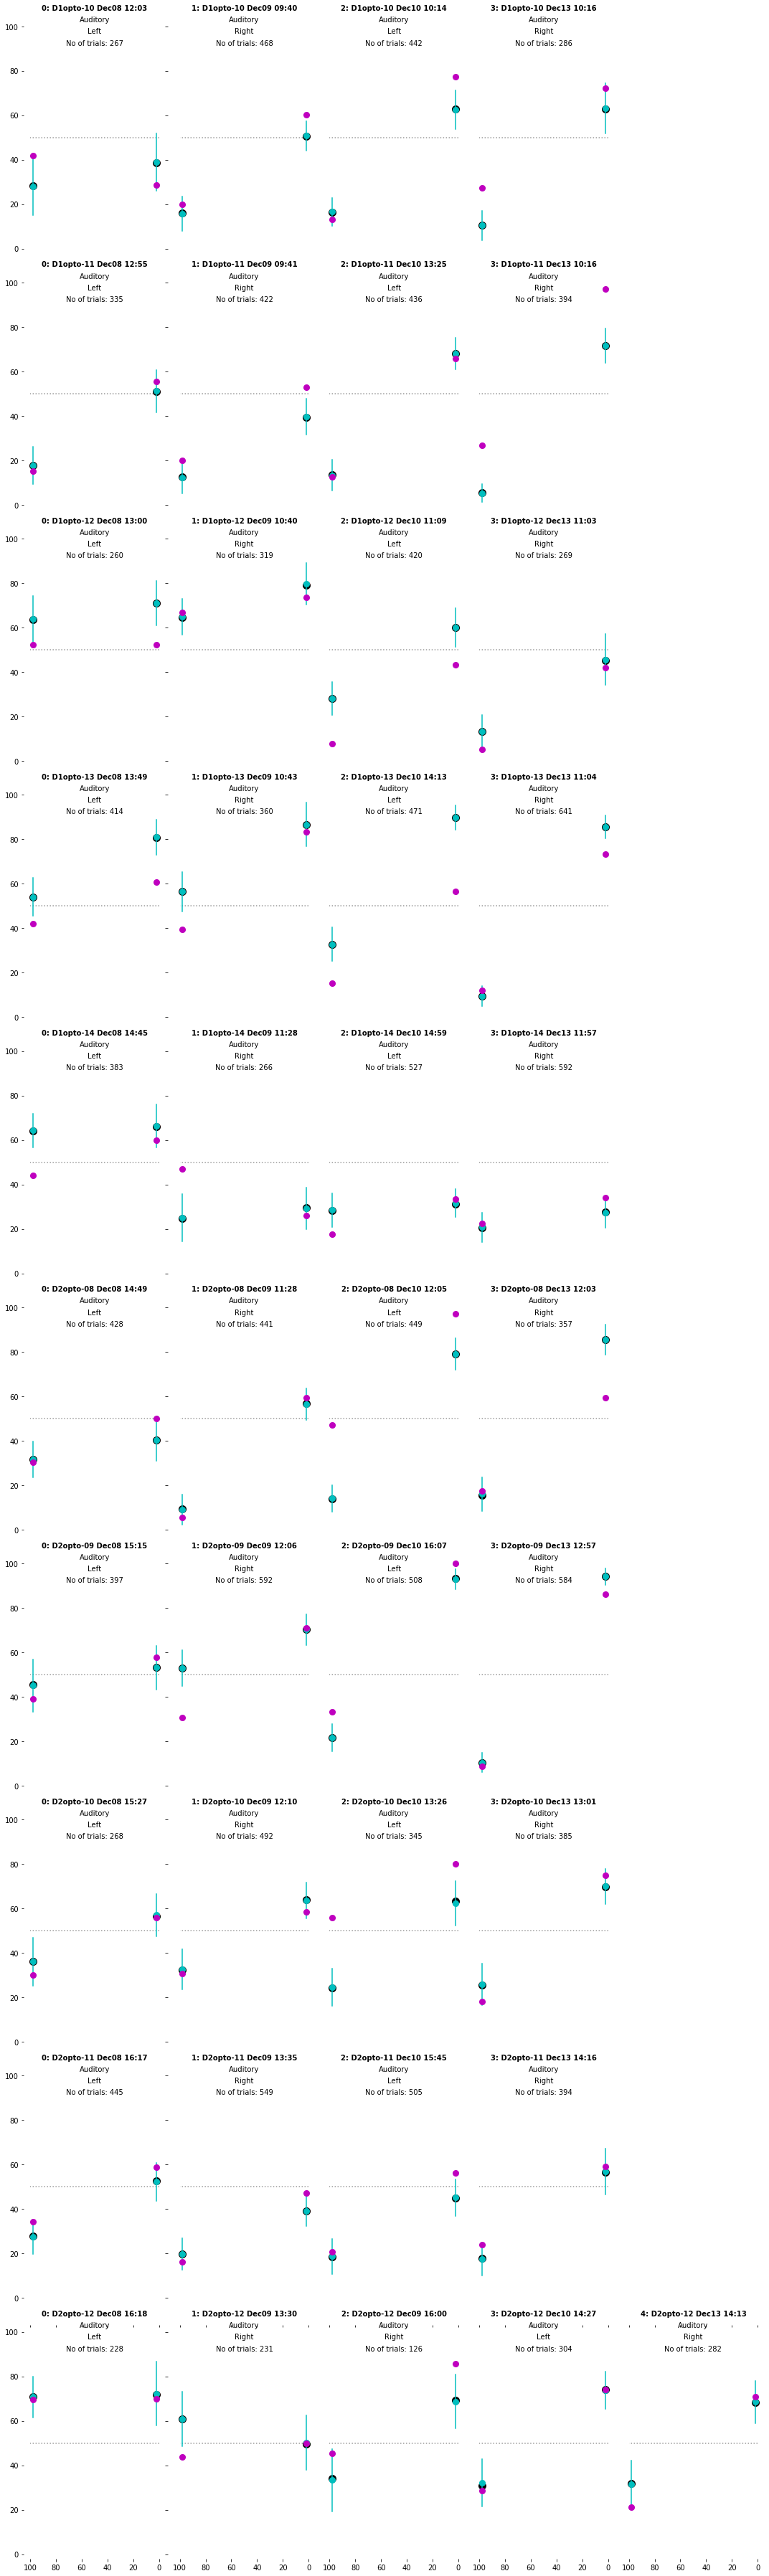

In [91]:
# plot the sessions
# Plot the data with the error bars for the random sampling

CondList = [(AnimalsDF['OptoStim']==0),
            (AnimalsDF['OptoStim']==1)]
ColorList = ['c', 'm']
LabelList = ['Normal', 'Opto']

n_cols = AnimalsDF.groupby('AnimalID')['SessionID'].nunique().max()

fig, axs = plt.subplots(len(pd.unique(AnimalsDF['AnimalID'])), n_cols,
                        figsize=(15, 5 * len(pd.unique(AnimalsDF['AnimalID']))),
                        facecolor='w', edgecolor='k')

fig.subplots_adjust(hspace = .2, wspace=1)

for ax in axs.ravel(): ax.axis('off')

for an_counter, animal in enumerate(pd.unique(AnimalsDF['AnimalID'])):
    animal_df = AnimalsDF[AnimalsDF['AnimalID'] == animal]
    
    for counter, session in enumerate(pd.unique(animal_df['SessionID'])):
        session_df = AnimalsDF[AnimalsDF['SessionID'] == session]
        
        ax = axs[an_counter, counter]        
        ax.hlines(50, 0, 100, linestyles='dotted', alpha=0.4)

        avail_diffs = random_opto_df[random_opto_df.SessionID == session].Difficulties.item()
        rand_choices_ds = random_opto_df[random_opto_df.SessionID == session].Random_choices.item()
        
        plot_utils.plot_random_optolike_choices(df=session_df,
                                                ax=ax,
                                                fake_dataset_m_and_std=[avail_diffs,
                                                                        np.mean(rand_choices_ds, axis=0),
                                                                        np.std(rand_choices_ds, axis=0)])
#         # overlay fits
#         for i, condition in enumerate(CondList):
#             plot_utils.plot_regression(df=animal_df[(animal_df['SessionID'] == session) & condition], ax=ax,
#                                        color=ColorList[i], label=LabelList[i], plot_points=False)
        #axs[counter].set_ylabel('')
        #axs[counter].set_xlabel('')
        ax.axis('on')
        # remove some ticks
        ax.tick_params(which='both', top=False, bottom='on', left='on', right=False,
                       labelleft='on', labelbottom='on')
        if not ax.is_first_col():
            ax.set_ylabel('')
            ax.set_yticks([])
        if not ax.is_last_row():
            ax.set_xlabel('')
            ax.set_xticks([])
                   
        ax.set_ylim(-2., 102.)
        #ax.legend(bbox_to_anchor=(1.05, 1), loc=0, borderaxespad=0.)
        ax.tick_params(which='both', top='off', bottom='on', left='on', right='off',
                       labelleft='on', labelbottom='on')
        # get rid of the frame
        for spine in ax.spines.values():
            spine.set_visible(False)
        
        plt.tight_layout()
        
        ax.invert_xaxis()
        
#         ax.get_legend().remove()
        ax.text(.5,1.05, str(counter) + ': ' + (session), \
                          horizontalalignment='center', fontweight='bold', transform=ax.transAxes)

        ax.text(.5,1, animal_df[(animal_df['SessionID'] == session)].Protocol.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.95, animal_df[(animal_df['SessionID'] == session)].Stimulation.unique()[0] , \
                          horizontalalignment='center', transform=ax.transAxes)
        ax.text(.5,.9, 'No of trials: ' + str(len(animal_df[(animal_df['SessionID'] == session)])) , \
                          horizontalalignment='center', transform=ax.transAxes)

    update_progress(an_counter / len(pd.unique(AnimalsDF['AnimalID'])))
    
update_progress(1)
plt.savefig(outputDir + output_directory_name + '_difficulty_significance_for_individual_opto_sessions.pdf', transparent=True, bbox_inches='tight')

plt.show(fig)

In [49]:
# add the performance of that session (use only the normal trials to compute this)
random_opto_df['session_performance'] = None

for session in pd.unique(random_opto_df['SessionID']):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get data for non-opto trials
    normal_df = AnimalsDF[(AnimalsDF['SessionID'] == session) & (AnimalsDF['OptoStim']==0)]
    # calculate performance
    sess_perf = 100 * np.nansum(normal_df.FirstPokeCorrect) / normal_df.shape[0]
    random_opto_df.at[session_idx, 'session_performance'] = sess_perf

In [62]:
# add the side in which stimulation happened, and translate the bias to contralateral / ipsilateral
random_opto_df['stimulated_side'] = None
random_opto_df['contralateral_bias'] = None

for session in pd.unique(random_opto_df['SessionID']):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()
    # get information
    stim_side = AnimalsDF[AnimalsDF['SessionID'] == session].Stimulation.unique().item()    
    # add info
    random_opto_df.at[session_idx, 'stimulated_side'] = stim_side

    # bias is the normal minus the opto. This means that a positive value is a leftwards bias of the opto trials
    # this is good as a contralateral bias for the trials in which optostimulation occurs in the right side
    # flip the sign of the ones where stimulation happens on the left
    if stim_side == 'Right':
        random_opto_df.at[session_idx, 'contralateral_bias'] = random_opto_df.at[session_idx, 'bias_mean']
    elif stim_side == 'Left':
        random_opto_df.at[session_idx, 'contralateral_bias'] = - random_opto_df.at[session_idx, 'bias_mean']
    else:
        print('Something wrong')

In [64]:
# Get a column with the mouse name
random_opto_df['AnimalID'] = None
# And the type of mouse
random_opto_df['Genotype'] = None

for sc, session in enumerate(pd.unique(random_opto_df['SessionID'])):
    session_idx = random_opto_df.index[random_opto_df.SessionID == session].item()    
    mouse_name = random_opto_df.loc[session_idx].SessionID.split(' ')[0]
    random_opto_df.at[session_idx, 'AnimalID'] = mouse_name
    random_opto_df.at[session_idx,'Genotype'] = mouse_name.split('-')[0]

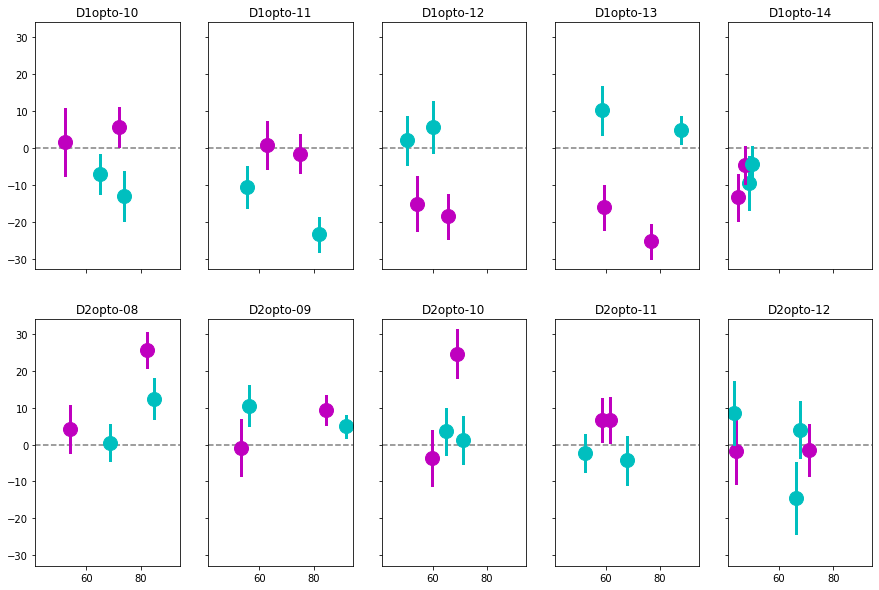

In [86]:
# plot for every mouse the contralateral bias vs the performance of the session
stim_types = ['Right', 'Left']
colors = ['c', 'm']
animals = pd.unique(random_opto_df.AnimalID)
fig, axs = plt.subplots(len(pd.unique(random_opto_df.Genotype)), 5,
                        figsize=(15, len(animals)),
                        sharex=True, sharey=True)
axs = axs.ravel()
# for ax in axs.ravel(): ax.axis('off')
for an_c, animal in enumerate(animals):
    ax = axs[an_c]
    ax.set_title(animal)
    ax.axhline(0, color='grey', linestyle='--')
    animal_rdf = random_opto_df[random_opto_df.AnimalID == animal]
    
    for session in pd.unique(animal_rdf.SessionID):
        session_idx = animal_rdf.index[animal_rdf.SessionID == session].item()
        st_t = animal_rdf.loc[session_idx].stimulated_side
        sp = animal_rdf.loc[session_idx].session_performance
        cb = animal_rdf.loc[session_idx].contralateral_bias
        cbs = animal_rdf.loc[session_idx].bias_std
        st_idx = stim_types.index(st_t)

        ax.plot(sp, cb, 'o', ms=14, color=colors[st_idx], alpha = 1)
        ax.plot([sp, sp], [cb-cbs, cb+cbs], color=colors[st_idx], linewidth=3)

plt.savefig(outputDir + output_directory_name + '_bias-through-learning_individual-animals.pdf', transparent=True, bbox_inches='tight')

plt.show()


